In [51]:
%load_ext autoreload
%autoreload 2

import torch
from rl4co.envs import CVRPTWEnv, DARPEnv, PDPTWEnv
from rl4co.envs.routing import CVRPTWGenerator, DARPGenerator, PDPTWGenerator
from rl4co.models import REINFORCE
from rl4co.utils.trainer import RL4COTrainer
from lightning.pytorch.callbacks import ModelCheckpoint, RichModelSummary
from rl4co.utils.decoding import rollout, random_policy
from rl4co.envs.common import RL4COEnvBase, Generator, get_sampler
from rl4co.models.zoo import AttentionModel, AttentionModelPolicy
from rl4co.utils.ops import gather_by_index, get_tour_length

from ortools_solver import solve_darp_with_ortools


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# generate PDPTW instances via PDPTWGenerator

In [57]:
td_init = PDPTWEnv(generator_params={"num_loc":30}).reset(batch_size=[1]).to(device)
td_init
print(solve_darp_with_ortools(td_init, vehicle_speed=5.0, time_limit_seconds=150, max_pdptw_vehicles=6))

[{'reward': -1021.9537777900696, 'route': [0, 21, 22, 25, 3, 26, 4, 17, 18, 11, 12, 0, 7, 8, 23, 24, 1, 2, 13, 14, 0, 27, 28, 9, 15, 10, 16, 29, 30, 0, 0, 5, 6, 19, 20, 0], 'routes': [[0], [21, 22, 25, 3, 26, 4, 17, 18, 11, 12, 0], [7, 8, 23, 24, 1, 2, 13, 14, 0], [27, 28, 9, 15, 10, 16, 29, 30, 0], [0], [5, 6, 19, 20, 0]]}]


In [58]:
print(td_init)

TensorDict(
    fields={
        action_mask: Tensor(shape=torch.Size([1, 31]), device=cpu, dtype=torch.bool, is_shared=False),
        capacity: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        current_loc: Tensor(shape=torch.Size([1, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        current_node: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        current_time: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        demand: Tensor(shape=torch.Size([1, 30]), device=cpu, dtype=torch.float32, is_shared=False),
        depot: Tensor(shape=torch.Size([1, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        depot_penalty: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        distances: Tensor(shape=torch.Size([1, 31]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1, 1]), de

In [29]:
td_init = PDPTWGenerator(num_loc=10)._generate(batch_size=[4])
print("FIELDS:", end=' ')
for key in list(td_init.keys()):
    print(key, end=', ')

for key in list(td_init.keys()):
    print(f"{key} size:  {td_init[key].shape}" )

for key in list(td_init.keys()):
    print(f"{key} content:  {td_init[0][key]}" )

# Vehicle_speed = 5

import torch
from examples.ortools_solver import solve_darp_with_ortools

td = td_init
print(solve_darp_with_ortools(td, vehicle_speed=5.0, time_limit_seconds=10))


FIELDS: depot, locs, capacity, time_windows, demand, durations, depot size:  torch.Size([4, 2])
locs size:  torch.Size([4, 10, 2])
capacity size:  torch.Size([4])
time_windows size:  torch.Size([4, 11, 2])
demand size:  torch.Size([4, 10])
durations size:  torch.Size([4, 11])
depot content:  tensor([ 3.5833, 81.9518])
locs content:  tensor([[13.8988, 78.9098],
        [30.3428, 95.8805],
        [22.8375, 77.0338],
        [ 7.4068, 61.4639],
        [72.4466, 53.1109],
        [12.6664,  9.6818],
        [ 6.5941, 33.7941],
        [45.8979, 16.8729],
        [19.3837, 38.6955],
        [40.1132, 69.8439]])
capacity content:  5.0
time_windows content:  tensor([[ 360., 1320.],
        [ 810.,  840.],
        [1020., 1050.],
        [ 450.,  480.],
        [ 600.,  630.],
        [ 510.,  540.],
        [ 690.,  720.],
        [ 900.,  930.],
        [1230., 1260.],
        [1110., 1140.],
        [1290., 1320.]])
demand content:  tensor([ 1., -1.,  3., -3.,  2., -2.,  1., -1.,  2., -2.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_new = model_ckpt.policy.to(device)
#env = new_model_checkpoint.env.to(device)
env = DARPEnv(generator_params={'num_loc': 30, "num_agents":6}) 

td_init = env.reset(batch_size=[1]).to(device)
out = policy_new(td_init.clone(), env, phase="test", decode_type="greedy")

print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out['actions'].cpu()):
    env.render(td, actions)
print(out)
print(td_init['time_windows'])


NameError: name 'model_ckpt' is not defined

In [7]:
td_init["locs"]

tensor([[[82.4591, 26.7164],
         [ 7.0160, 17.8390],
         [84.1597, 39.4536],
         [71.6743, 73.3700],
         [70.6872, 11.9826],
         [28.3388, 40.9926],
         [56.8374, 88.2305],
         [38.3072, 94.4154],
         [41.2633,  4.4585],
         [47.7275, 88.2238],
         [ 3.0717,  1.7965]]])

{'reward': tensor([-579.7537]), 'actions': tensor([[ 1,  2,  0,  3,  4,  0,  9, 10,  7,  8,  5,  6,  0]]), 'successful_requests': tensor([5.])}
tensor([[48, 29, 33, 28, 30, 29, 31, 25, 27, 12, 15]])


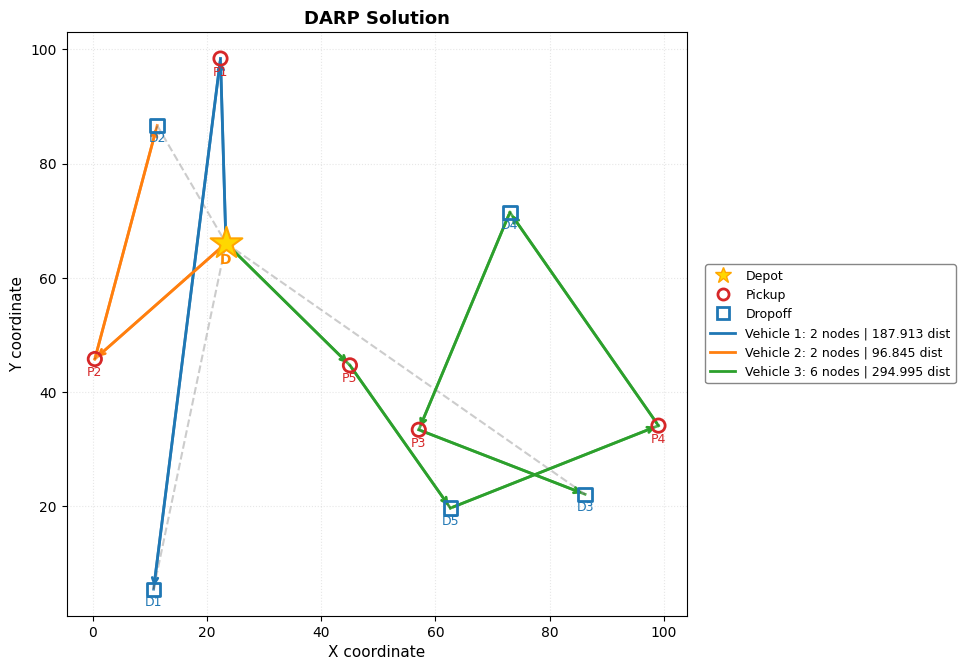

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = DARPEnv(generator_params={'num_loc': 10, "num_agents":6}) 

td_init = env.reset(batch_size=[1]).to(device)

or_out = solve_darp_with_ortools(td_init, time_limit_seconds=5)

for td, actions in zip(td_init, or_out['actions'].cpu()):
    env.render(td, actions)
print(or_out)
print(td_init['time_windows'])

{'reward': tensor([-676.2397]), 'log_likelihood': tensor([-0.1276], grad_fn=<SumBackward1>), 'successful_requests': tensor([5.]), 'actions': tensor([[ 9, 10,  7,  8,  1,  2,  5,  6,  0,  3,  4]])}
tensor([[48, 24, 28, 16, 21, 27, 31, 29, 33, 25, 27]])


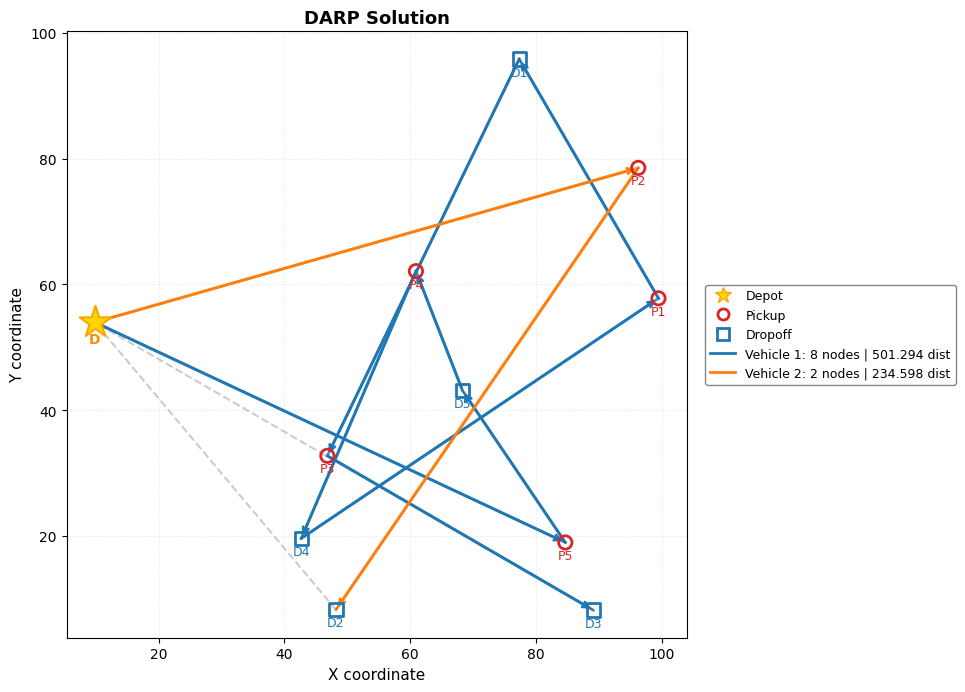

In [35]:
out = policy_new(td_init.clone(), env, phase="test", decode_type="greedy")

for td, actions in zip(td_init, out['actions'].cpu()):
    env.render(td, actions)
print(out)
print(td_init['time_windows'])

# Comparison

 83%|███████████████████████████████████████▏       | 5/6 [04:10<00:50, 50.13s/it]

  - Vehicle 1, Node 19: time 23.00 + travel 1.92 = 24.92 > window 23
No solution found!
No solution found!
No solution found!
No solution found!


100%|███████████████████████████████████████████████| 6/6 [05:00<00:00, 50.12s/it]

  - Vehicle 1, Node 5: time 14.00 + travel 0.39 = 14.39 > window 14
             loc=10    loc=14    loc=18    loc=22     loc=26  loc=30
agents=6  10.145503  1.406858  3.838012 -1.477981 -10.543385     NaN


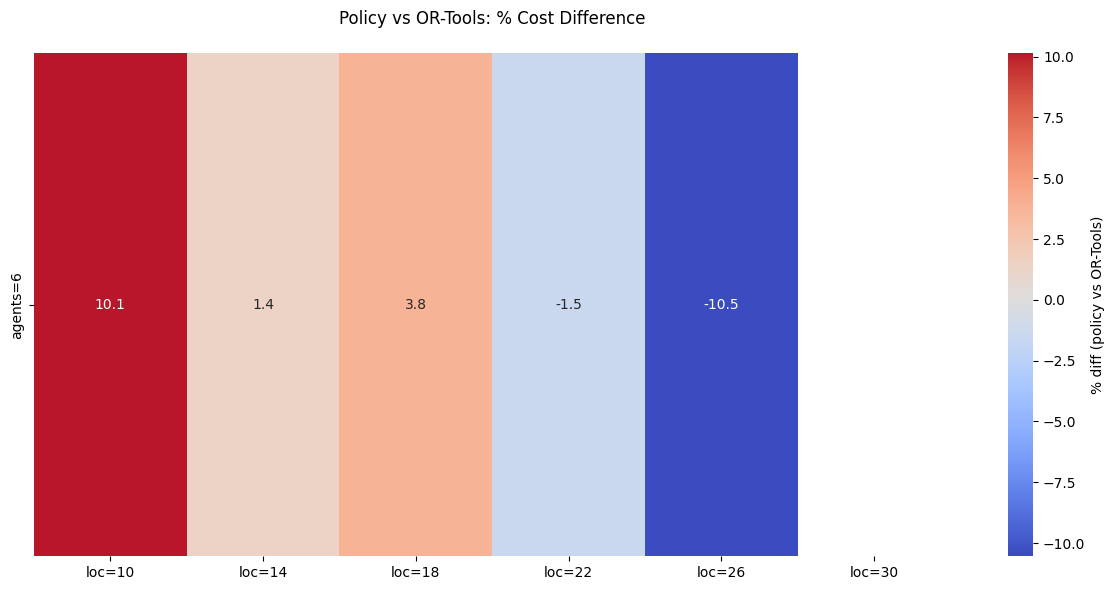

In [13]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
# your pieces: assumed to exist
# from your_module import DARPEnv, solve_darp_with_ortools, policy_new

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_loc_list = [10, 14, 18, 22, 26, 30]   # 6 columns
num_agents_list = [6]            # 4 rows
n_eval = 5                                # increase for smoother numbers

# To store results
pct_table = []

for na in num_agents_list:
    row_vals = []
    for nl in tqdm(num_loc_list):
        # collect rewards over episodes
        or_rewards = []
        pol_rewards = []

        # build env for this setting
        # (if your DARPEnv signature is different, adjust here)
        env = DARPEnv(generator_params={
            "num_loc": nl,
            "num_agents": na,
        })

        for _ in range(n_eval):
            # reset once and send to device
            td_init = env.reset(batch_size=[1]).to(device)

            # OR-Tools solve
            or_out = solve_darp_with_ortools(td_init, time_limit_seconds=10)
            # or_out['reward'] is a tensor([-452.5]) per your example
            or_reward = or_out["reward"].detach().cpu().item()

            # Policy run on the *same* initial state
            pol_out = policy_new(td_init.clone(), env, phase="test", decode_type="greedy")
            pol_reward = pol_out["reward"].detach().cpu().item()

            or_rewards.append(or_reward)
            pol_rewards.append(pol_reward)

        # average
        avg_or = sum(or_rewards) / len(or_rewards)
        avg_pol = sum(pol_rewards) / len(pol_rewards)

        # guard against 0 (shouldn't happen often, but just in case)
        if abs(avg_or) < 1e-6:
            pct_diff = 0.0
        else:
            pct_diff = 100.0 * (avg_pol - avg_or) / abs(avg_or)

        row_vals.append(pct_diff)
    pct_table.append(row_vals)

# make DataFrame: rows = num_agents, cols = num_loc
df = pd.DataFrame(
    pct_table,
    index=[f"agents={na}" for na in num_agents_list],
    columns=[f"loc={nl}" for nl in num_loc_list],
)

print(df)

# seaborn-style 4x6 heatmap
plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    df,
    annot=True,
    fmt=".1f",
    cmap="coolwarm",
    center=0,
    cbar_kws={"label": "% diff (policy vs OR-Tools)"}
)
ax.set_title("Policy vs OR-Tools: % Cost Difference\n")
plt.tight_layout()
plt.show()

In [78]:
or_out

{'reward': tensor([-452.5291]),
 'actions': tensor([[ 3,  4,  7,  8,  9,  1, 10,  2,  0,  5,  6,  0]]),
 'successful_requests': tensor([5.])}